# Part 1: Environments and Actor Critic
#### Project by Hanqing Li, Kumar Utkarsh, Richard Suhendra
### Goal:
Our goal is to here is to introduce the two gym environments we are using, as well as to implement the vanilla Actor Critic method.

### Environment 1: gym-BipedalWalker-v3

![BPWalker](https://user-images.githubusercontent.com/36446402/79070954-7a11b000-7cf6-11ea-8160-fb86e0a174e1.gif)

This is a 4-joint walker robot environment, a part of Box2D environments. The Bipedal Walker walks on a rough terrain.

**Action Space:** Actions are motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees. *Shape*: Box(-1.0, 1.0, (4,), float32).

**Observation Shape:** Consists of hull angle speed, angular velocity, horizontal speed, vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There are no coordinates in the state vector. *Shape*: (24,)

**Reward:** Reward is given for moving forward, totaling 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points. A more optimal agent will get a better score.

### Environment 2: gym-Walker2d-v2

![Walker](https://openai.com/content/images/2017/05/image2.gif)

The walker is a two-dimensional two-legged figure that consist of four main body parts, unlike BipedalWalker which has two. This environment builds on the hopper environment. 

**Action Space:** An action represents the torques applied at the hinge joints at thighs, legs and foot. *Shape*: Box(-1.0, 1.0, (6,), float32).

**Observation Shape:** Observations consist of positional values of different body parts of the walker, followed by the velocities of those individual parts= with the each position ordered before the respective velocity. *Shape*: (16,)

**Reward:** The reward consists of three parts: *1. healthy_reward*: Every timestep that the walker is alive, it is rewarded a fixed value called healthy_reward, *2. forward_reward*: A reward of walking forward which is measured as forward_reward_weight. *3. ctrl_cost*: A cost for penalising the walker if it takes actions that are too large.
The total reward returned is *reward = healthy_reward bonus + forward_reward - ctrl_cost*.

# Actor-Critic Method

The vanilla policy gradient can be re-written as follows:
$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau}[\sum_{t=0}^{T-1}\nabla_{\theta}\log \pi_{\theta}(a_t|s_t)G_t]$$
$$\Rightarrow \nabla_{\theta} J(\theta) = \mathbb{E}_{s_0,a_0,...,s_t,a_t}[\sum_{t=0}^{T-1}\nabla_{\theta}\log \pi_{\theta}(a_t|s_t)]\cdot\mathbb{E}_{r_{t+1},s_{t+1},...,r_T,s_t}[G_t]$$
$$\Rightarrow \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau}[\sum_{t=0}^{T-1}\nabla_{\theta}\log \pi_{\theta}(a_t|s_t)]\mathbf{Q_w(s_t,a_t)}$$

Actor-Critic Method then combines the strengths of policy gradient methods and that of value function approximation methods in the following way:
1. The Critic estimates the value function, which can either be the $Q$-value (action) or the $V$-value (state).
2. The Actor updates the policy distribution as suggested by the Critic.

The Actor and Critic policies are traditionally updated by minimizing the following losses:
$$ CriticLoss = \delta_t = (r+\gamma V_{\pi}(s_{t+1})-V_{\pi}(s_t))^2 $$
$$ ActorLoss = -\log(\mathcal{N}(a|\mu(s_t),\sigma(s_t)))\cdot \delta_t $$,
where $\mathcal{N}(a|\mu,\sigma)$ is the Normal Probability Distribution that represents the stochastic policy. However, here we consider the $CriticLoss = (r+\gamma Q(s_{t+1},a)-Q(s_t, \pi(s_t)))^2$ and $ActorLoss = -\sum_{s,a}Q(s,a)$. Doing this we focus on maximizing the direct rewards.

The Actor and Critic functions are parametrized with neural networks (denoted by $w$ in the last equation). Following is a PyTorch implementation of the Actor Critic Method on the two environments.

# Actor Critic Application on two Environments

In [ ]:
!pip install box2d-py
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install free-mujoco-py

In [ ]:
import gym
import os
import numpy as np
import torch
from torch.autograd import Variable
import gc

#locate the 
os.chdir('drive/MyDrive/reinforcement_learning/Continuous_Mountain_Car')

In [ ]:
import train
import buffer

We use BipedalWalker(version 3) and Walker2d(version 2) to test the actor critic algorithm. The max episodes is 5000 for BidedalWalker and 1000 for Walker2d. The max steps is 1000 and the max buffer size is 1000000. During training we use exploration strategy (action generated by actor and added with noise) to get actions and store the tuple of (current state, action, reward, new state) in buffer. Then after each episode we sample 128 tuples from buffer to train actor and critic network. After training, we rerun the environment by exploitation strategy (action generated by target actor) for validation of each episode.

In [ ]:
#env = gym.make("BipedalWalker-v3")
env = gym.make('Walker2d-v2')

In [ ]:
MAX_EPISODES = 1000 #=5000 for bipedal walker

MAX_STEPS = 1000
MAX_BUFFER = 1000000
MAX_TOTAL_REWARD = 5000

S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_MAX = env.action_space.high[0]

print(' State Dimensions :- ', S_DIM)
print(' Action Dimensions :- ', A_DIM)
print(' Action Max :- ', A_MAX)

ram = buffer.MemoryBuffer(MAX_BUFFER)
trainer = train.Trainer(S_DIM, A_DIM, A_MAX, ram)

 State Dimensions :-  17
 Action Dimensions :-  6
 Action Max :-  1.0


In [ ]:
from tqdm.notebook import trange
import json
val_steps_path = 'val_steps_walker2d.txt'
train_steps_path = 'train_steps_walker2d.txt'
final_reward_path = 'final_reward_walker2d.txt'
train_reward_path = 'train_reward_walkder2d.txt'
validation_steps = []
train_steps = []
final_rewards = []
train_rewards = []

for ep in trange(MAX_EPISODES):
  state = env.reset()
  train_r = 0
  train_step = 0
  #print('EPISODE :- ', ep)
  for step in range(MAX_STEPS):
    train_step += 1
    state = np.float32(state)
    
		# get action based on observation, use exploration policy here
    action = trainer.get_exploration_action(state)
   
    new_state, reward, done, info = env.step(action)
    
    train_r += reward
    #push this experiment to buffer
    if done:
      new_state = None
    else:
      new_state = np.float32(new_state)
      ram.add(state, action, reward, new_state)
    
    state = new_state

    # perform optimization
    trainer.optimize()
    #train critic and actor network
    if done:
      break
  train_steps.append(train_step)
  train_rewards.append(train_r)

  #validation
  total_r = 0
  final_step = 0
  state = env.reset()
  for step in range(MAX_STEPS):
    final_step += 1
    state = np.float32(state)

    
    action = trainer.get_exploitation_action(state)

    new_state, reward, done, info = env.step(action)

    total_r += reward
    new_state = np.float32(new_state)
    state = new_state
    if done:
      break

  validation_steps.append(final_step)
  final_rewards.append(total_r)

  #check memory consumption and clear memory
  gc.collect()

  if ep%10 == 0:
    trainer.save_models(ep)

with open(val_steps_path, 'w') as f:
  json.dump(validation_steps, f)
with open(final_reward_path, 'w') as f:
  json.dump(final_rewards, f)
with open(train_reward_path, 'w') as f:
  json.dump(train_rewards, f)
with open(train_steps_path, 'w') as f:
  json.dump(train_steps, f)
#print('Completed episodes')

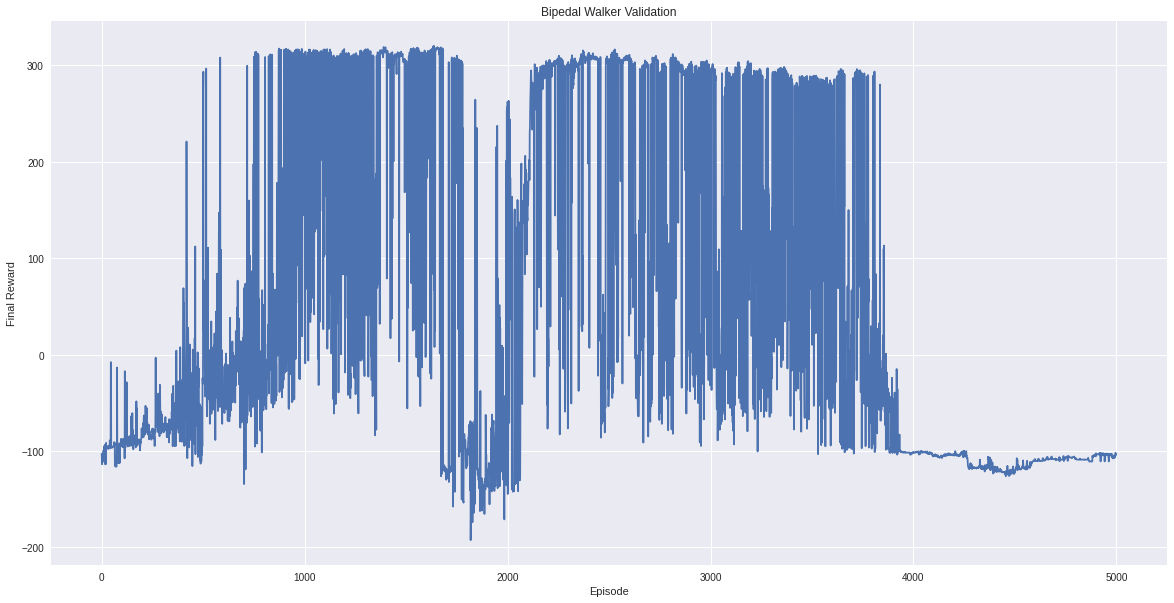

In [ ]:
import matplotlib.pyplot as plt
import json
plt.style.use('seaborn')

final_reward_path = 'final_reward_bipedal.txt'
with open(final_reward_path, 'r') as f:
  bipedal_reward = json.load(f)
fig, ax = plt.subplots(1, figsize = (20, 10))
_ = ax.plot(bipedal_reward)
_ = ax.set_title('Bipedal Walker Validation')
_ = ax.set_xlabel('Episode')
_ = ax.set_ylabel('Final Reward')

The validation reward for Bipedal Walker is pretty noisy. The reward goes to 300+ after 900 episodes of training and becomes more stable after 2100 episodes of training. After 4000 episode the model getting stucked at falling.

It reaches max reward at episode 106


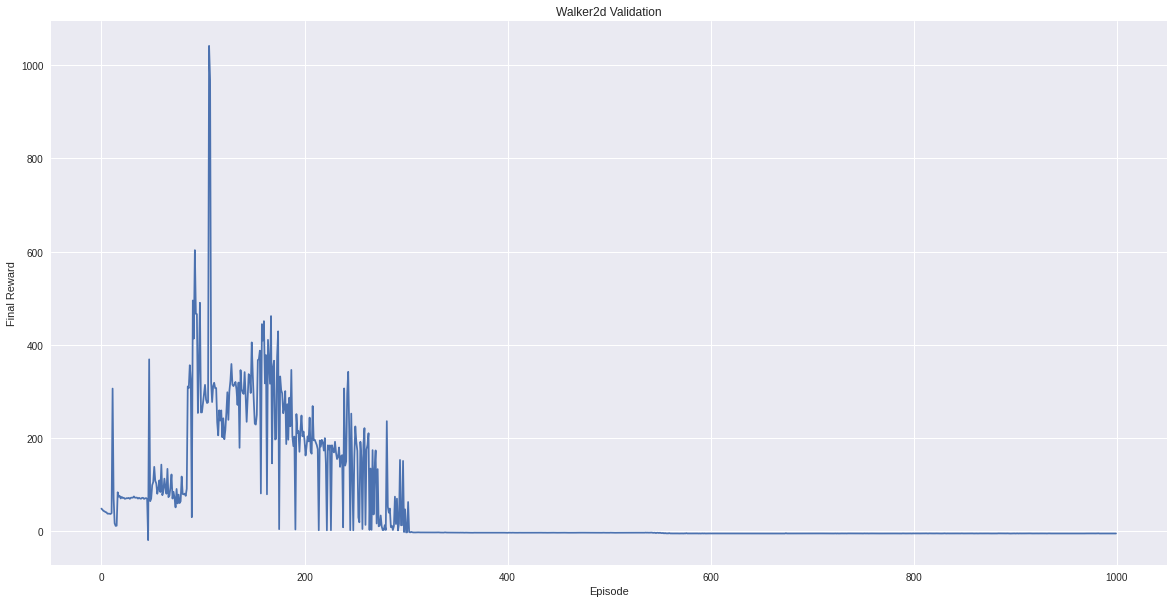

In [ ]:
final_reward_path = 'final_reward_walker2d.txt'
with open(final_reward_path, 'r') as f:
  walker2d_reward = json.load(f)
fig, ax = plt.subplots(1, figsize = (20, 10))
_ = ax.plot(walker2d_reward)
_ = ax.set_title('Walker2d Validation')
_ = ax.set_xlabel('Episode')
_ = ax.set_ylabel('Final Reward')
print(f'It reaches max reward at episode {np.argmax(walker2d_reward)}')

The validation reward for Walker 2d is less noisy. The model gets better from episode 0 to 150 and then gets worse after 150 episode. After episode 250 the reward stays near zero.

In [ ]:
#extract model at episode 2400 and run for 100 episodes to see how it goes for bipedal walker
env = gym.make("BipedalWalker-v3")
S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_MAX = env.action_space.high[0]
ram = buffer.MemoryBuffer(MAX_BUFFER)
tester = train.Trainer(S_DIM, A_DIM, A_MAX, ram)
tester.load_models(2400)

test_reward_path = 'test_reward_bipedal.txt'
test_steps_path = 'test_steps_bipedal.txt'
test_rewards = []
test_steps = []

test_episodes = 100

for ep in trange(test_episodes):
  state = env.reset()
  test_r = 0
  test_step = 0
  for step in range(MAX_STEPS):
    test_step += 1
    state = np.float32(state)
    
		# get action based on observation, use exploration policy here
    action = tester.get_exploitation_action(state)
   
    new_state, reward, done, info = env.step(action)
    
    test_r += reward
    #push this experiment to buffer
    if done:
      new_state = None
    else:
      new_state = np.float32(new_state)
    
    state = new_state

   
    #train critic and actor network
    if done:
      break
  test_steps.append(test_step)
  test_rewards.append(test_r)

with open(test_steps_path, 'w') as f:
  json.dump(test_steps, f)
with open(test_reward_path, 'w') as f:
  json.dump(test_rewards, f)

In [ ]:
#extrac model at episode 110 and run it 100 times to test. Walker2d
env = gym.make("Walker2d-v2")
S_DIM = env.observation_space.shape[0]
A_DIM = env.action_space.shape[0]
A_MAX = env.action_space.high[0]
ram = buffer.MemoryBuffer(MAX_BUFFER)
tester = train.Trainer(S_DIM, A_DIM, A_MAX, ram)
tester.load_models(110)

test_reward_path = 'test_reward_walker2d.txt'
test_steps_path = 'test_steps_walker2d.txt'
test_rewards = []
test_steps = []

test_episodes = 100

for ep in trange(test_episodes):
  state = env.reset()
  test_r = 0
  test_step = 0
  for step in range(MAX_STEPS):
    test_step += 1
    state = np.float32(state)
    
		# get action based on observation, use exploration policy here
    action = tester.get_exploitation_action(state)
   
    new_state, reward, done, info = env.step(action)
    
    test_r += reward
    #push this experiment to buffer
    if done:
      new_state = None
    else:
      new_state = np.float32(new_state)
    
    state = new_state

   
    #train critic and actor network
    if done:
      break
  test_steps.append(test_step)
  test_rewards.append(test_r)

with open(test_steps_path, 'w') as f:
  json.dump(test_steps, f)
with open(test_reward_path, 'w') as f:
  json.dump(test_rewards, f)

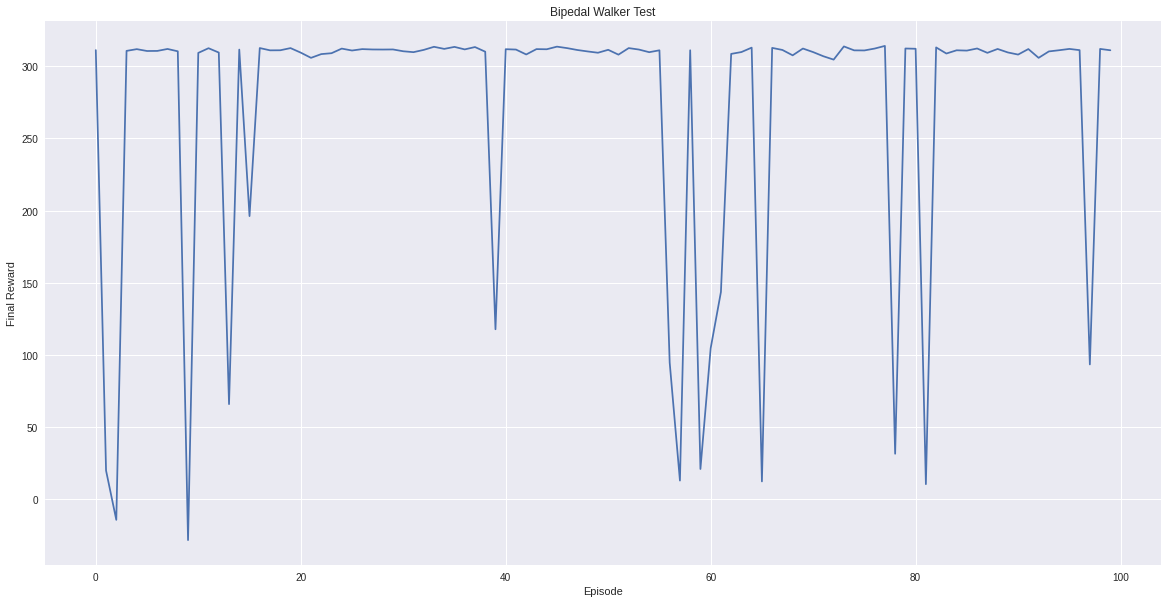

In [ ]:
test_reward_path = 'test_reward_bipedal.txt'
with open(test_reward_path, 'r') as f:
  bipedal_test_reward = json.load(f)
fig, ax = plt.subplots(1, figsize = (20, 10))
_ = ax.plot(bipedal_test_reward)
_ = ax.set_title('Bipedal Walker Test')
_ = ax.set_xlabel('Episode')
_ = ax.set_ylabel('Final Reward')

For testing, we load the model at episode 2400 for Bipedal Walker and run model using exploitation strategy for 100 episodes to observe the final reward at each episode. Acoording to the plot above, the final reward is above 300 for most episode and the averge reward is 279 which is close to 300. The actor-critic model works well for Bipedal Walker.

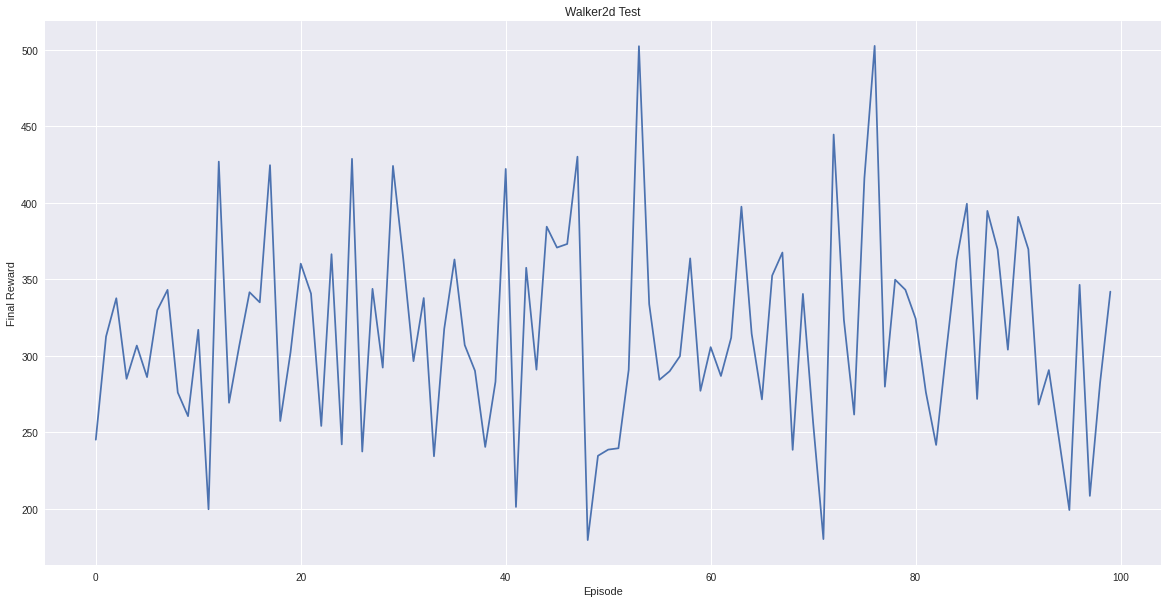

In [ ]:
test_reward_path = 'test_reward_walker2d.txt'
with open(test_reward_path, 'r') as f:
  bipedal_test_reward = json.load(f)
fig, ax = plt.subplots(1, figsize = (20, 10))
_ = ax.plot(bipedal_test_reward)
_ = ax.set_title('Walker2d Test')
_ = ax.set_xlabel('Episode')
_ = ax.set_ylabel('Final Reward')

We load model at episode 110 to test walker2d. The final return is vibrating around 300. The actor-critic model does not perform really well on this environment.